# Setup

Import basic packages and bring in lookup tables for clinical conditions and medications and pre-defined mapping functions.

#### Packages

In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime, timedelta
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import combinations
# set number of rows pandas dataframe displays
pd.set_option('display.max_rows', 3000)

#### Lookup tables

In [2]:
lkp_med = pd.read_csv('S:\CALIBER_17_205R\MSc\Oliver\Lookup Tables\lookup_medical_table.csv', sep=',')
lkp_med_code_dic = pickle.load(open('S:\CALIBER_17_205R\MSc\Oliver\Python Code\lkp_med_code_dic.p', 'rb'))
lkp_med_term_dic = pickle.load(open('S:\CALIBER_17_205R\MSc\Oliver\Python Code\lkp_med_term_dic.p', 'rb'))

lkp_bnf = pd.read_csv('S:\CALIBER_17_205R\MSc\Oliver\Lookup Tables\lookup_bnf_table.csv', 
                      sep=',', dtype={'bnfcode':str, 'bnf':str})

lkp_prd = pd.read_csv('S:\CALIBER_17_205R\MSc\Oliver\Lookup Tables\lookup_product_table.csv', sep=',', 
                      low_memory=False)

#### Mappings from helper_functions

In [3]:
from helper_functions import medcode_to_read, medcode_to_term, read_to_medcode, cprd_to_bnf
from helper_functions import bnf_to_chapter, get_stat_dic, make_confusion_matrix

#### Disease readcode lists

Predominantly taken from ClinicalCodes.org

In [4]:
# diabetes
db_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\diabetes.csv', sep=',')
diabetes_readcodes = list(db_csv['code'])

# heart-failure
hf_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\heart-failure.csv', sep=',')
heartfailure_readcodes = list(hf_csv['code'])

# thrombosis
tm_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\res25-p16_thrombosis.csv', sep=',')
thrombosis_readcodes = list(tm_csv['code'])

# mild-liver-disease
ld_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\res27-mild-liver-disease.csv', sep=',')
liverdisease_readcodes = list(ld_csv['code'])

# renal-disease
rd_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\res27-renal-disease.csv', sep=',')
renaldisease_readcodes = list(rd_csv['code'])

# hypertension
ht_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\hypertension.csv', sep=',')
hypertension_readcodes = list(ht_csv['code'])

Construct disease_dic from the readcodes specified above, to feed into the build_data function

In [5]:
disease_dic = {'db':diabetes_readcodes,
               'hf':heartfailure_readcodes,
               'tm':thrombosis_readcodes,
               'ld':liverdisease_readcodes,
               'rd':renaldisease_readcodes,
               'ht':hypertension_readcodes}

# Get Multi-Classification Data

In [6]:
# target, version and eventdate of selected classifier
target = 'patids_v1a_pos'
version = 'v1'
eventdate = 'eventdate_min'
filter_type = 'filter_12_mnth'

In [7]:
# complete list of hyptertension treatements by bnfchapter
drug_list = [5, 17, 135, 142]

# initialize data dictionary
ht_data_dic = {}

for drug in drug_list:
    
    # get processed data for each drug and save within ht_data_dic
    stat_dic, target_list, _, filter_6_mnth, filter_12_mnth = get_stat_dic(drug)
    ht_data_dic[drug] = {'stat_dic':stat_dic,
                         'target_list':target_list,
                         'filter_6_mnth':filter_6_mnth,
                         'filter_12_mnth':filter_12_mnth}
    
    # get required items from the ht_data_dic
    filtr = ht_data_dic[drug][filter_type]
    
    # get positive instances and filter to within the X month window required
    patids_pos = [patid for patid in list(stat_dic.keys()) if stat_dic[patid]['target'][target][0]==1]
    patids_pos = list(set.intersection(set(patids_pos), set(filtr)))    
    
    # add these positive patids to the ht_data_dic
    ht_data_dic[drug][f'{target}_{filter_type}'] = patids_pos

##################################### THIS CODE MUST ALL BE RUN AT THE SAME TIME #####################################
    
# initialize duplicate and comb patid lists
dup_patids = []
comb_patids = []

for drug_a in drug_list:
    for drug_b in drug_list:
        if drug_a!=drug_b:
            dup_patids = dup_patids + (list(set.intersection(set(ht_data_dic[drug_a][f'{target}_{filter_type}']), 
                                                             set(ht_data_dic[drug_b][f'{target}_{filter_type}']))))
    
    # get a combined list of patids
    comb_patids = list(set.union(set(comb_patids), set(ht_data_dic[drug_a][f'{target}_{filter_type}'])))
    
    # remove duplicate patids from each drug specific patids_pos
    ht_data_dic[drug_a].update({f'{target}_{filter_type}': list(set(ht_data_dic[drug_a][f'{target}_{filter_type}']) -\
                                                                set(dup_patids))}) 
        
# get unique duplicate patids
dup_patids = list(set(dup_patids))
# remove duplicate patids from comb_patids
comb_patids = list(set(comb_patids)-set(dup_patids))

In [8]:
# can't use helper function here because we only want data for a specific set of patients

dic = {}

y = []
X_bnf = []
n_bnf = len(list(lkp_bnf['bnfcode']))

row = 0

for col, drug in enumerate(drug_list):
    
    stat_dic = ht_data_dic[drug]['stat_dic']
    
    for patid in ht_data_dic[drug][f'{target}_{filter_type}']:
        
        y.append(col)
        X_bnf.append([0 if (k+1) not in stat_dic[patid]['meds_min'] else 1 for k in range(n_bnf)])
        row+=1
        
# re-format the data
y = np.array(y)
X_bnf = np.array(X_bnf)

# dummy column to start building from
X = np.zeros((len(comb_patids),1))
# idx to map column to feature
idx = 0

X = np.concatenate((X, X_bnf), axis=1)
unknown_idx = 0
for bnfcode in range(n_bnf):
    # !note there are duplicate mappings, so appending an index to make each mapping unique
    try:
        mapping = bnf_to_chapter(cprd_to_bnf(bnfcode+1, lkp_bnf), lkp_prd).item()
        if mapping=='-':
            dic[idx] = f'Unknown Chapter {unknown_idx}'
            unknown_idx += 1
        elif mapping in list(dic.values()):
            dic[idx] = f'{mapping} (repeated)' # don't need to index here bcs max duplication is 2
        else:
            dic[idx] = mapping
    except ValueError:
        dic[idx] = f'Unknown Chapter {unknown_idx}'
        unknown_idx += 1
    idx += 1

# delete dummy column before returning
X = np.delete(X, 0, axis=1)

In [9]:
# MASK HYPERTENSIVE BNFCHAPTERS (idx = [8, 20, 138, 145] when all feature groups included)
delete_idx_list = [4, 16, 134, 141]

for idx in delete_idx_list:
    dic.pop(idx)

X = np.delete(X, delete_idx_list, axis=1)  

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTEN
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from helper_functions import add_neg_patids, build_data

Cross-validation will be done over 5 folds

In [13]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=0)

### GridsearchCV for best hyper-parameters

#### Split data in to top level train and test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/6, random_state=0, shuffle=True)

#### Undersample majority classes for 5-fold CV gridsearch to avoid data leakage

In [15]:
undersample = RandomUnderSampler(random_state=0)

X_train_gs, y_train_gs = undersample.fit_resample(X_train, y_train)
X_test_gs, y_test_gs = undersample.fit_resample(X_test, y_test)

# use dic to map columns to feature names
X_train_gs_df = pd.DataFrame(data=X_train_gs, columns=list(dic.values()))
X_test_gs_df = pd.DataFrame(data=X_test_gs, columns=list(dic.values()))

In [16]:
grid_params = {'objective':['multi:softmax'], 'eval_metric':['merror'], 
               # if not gridsearch, set large enough thatnever reached because applying early stopping criteria
               'n_estimators':[100], 
               'max_depth':[1,2,3,4,5,6], 'eta':[0.1,0.2,0.3], 'min_child_weight':[1,3,5,7,9,11],
               'colsample_bytree':[0.7,0.8,0.9,1.0], 'num_class':[4]}

# using SKLearn API for grid search and better printing of trees
model = xgb.XGBClassifier(use_label_encoder=False)
gridsearch = GridSearchCV(model, grid_params, scoring='accuracy', refit=True, cv=5)
gridsearch.fit(X_train_gs_df, y_train_gs.flatten(), early_stopping_rounds=5, # 5 implied from learning curve
               eval_set=[(X_test_gs_df, y_test_gs.flatten())],
               verbose=False)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use_label_encoder=False,
                                     validate_parameters=None, verbosity=None),
             param_grid={'colsample_bytree': [0

In [17]:
gridsearch.best_score_

0.3219806763285024

In [18]:
gridsearch.best_params_

{'colsample_bytree': 1.0,
 'eta': 0.2,
 'eval_metric': 'merror',
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 100,
 'num_class': 4,
 'objective': 'multi:softmax'}

In [19]:
# save best booster
pickle.dump(gridsearch.best_estimator_.get_booster(), open('mc_booster_best_31082021.p', 'wb'))

In [20]:
# save best estimator
pickle.dump(gridsearch.best_estimator_, open('mc_estimator_best_31082021.p', 'wb'))

In [21]:
# save best estimator
pickle.dump(gridsearch, open('mc_gridsearch_31082021.p', 'wb'))

### Train model on all data

#### Parameters from gridsearch

In [11]:
params = {'colsample_bytree': 1.0,
          'eta': 0.2,
          'eval_metric': 'merror',
          'max_depth': 2,
          'min_child_weight': 1,
          'num_class': 4,
          'objective': 'multi:softmax'}

#### Define oversampler for subsequent analysis

In [12]:
# oversample = SMOTEN() # - not suitable, always predicts 142: suspected data leakage
oversample = RandomOverSampler(random_state=0)

#### Establish optimum number of training rounds

In [26]:
num_boost_round = 100

# initialize training and test auc score lists
tr_epoch_as = []
te_epoch_as = []

k_fold_index_set = list(kf.split(X))

for fold in range(k_folds):
    
    evals_result = {}

    # split the data in to the k-th fold using SKLearn k-fold split
    train_idx, test_idx = k_fold_index_set[fold]
    X_train_k, y_train_k, X_test_k, y_test_k = X[train_idx], y[train_idx], X[test_idx], y[test_idx]
    
    # oversample to get balanced dataset
    X_train_k, y_train_k = oversample.fit_resample(X_train_k, y_train_k)
    X_test_k, y_test_k = oversample.fit_resample(X_test_k, y_test_k)

    # get data in required format for XGBoost
    dtrain_k = xgb.DMatrix(X_train_k, label=y_train_k, feature_names=list(dic.values()))
    dtest_k = xgb.DMatrix(X_test_k, label=y_test_k, feature_names=list(dic.values()))

    # using Learning API in XGBoost so that can store feature_names within the dMatrix
    evals = [(dtrain_k, 'dtrain_k'), (dtest_k, 'dtest_k')] # early stopping on the last item in evals (so test)
    model = xgb.train(params, dtrain_k, num_boost_round, evals=evals,
                      evals_result=evals_result, verbose_eval=False)

    # get accuracy score from evals_test for train and test
    tr_epoch_as.append(np.array(list(evals_result['dtrain_k'].values())[0]))
    te_epoch_as.append(np.array(list(evals_result['dtest_k'].values())[0]))

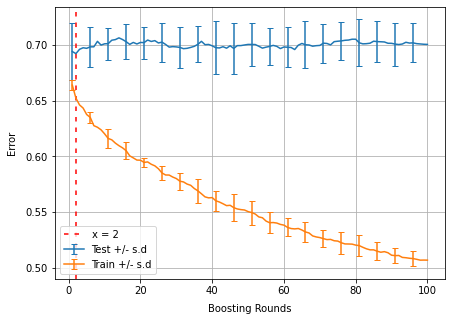

optimal training rounds: 2
optimal error: 0.6920767999999999


In [27]:
plt.figure(figsize=(7,5))
line_b = plt.errorbar((np.linspace(1,100,100)), np.mean(np.array(te_epoch_as), axis=0), 
             yerr=np.std(np.array(te_epoch_as), axis=0), errorevery=5, capsize=3, label='Test +/- s.d')

line_a = plt.errorbar((np.linspace(1,100,100)), np.mean(np.array(tr_epoch_as), axis=0), 
             yerr=np.std(np.array(tr_epoch_as), axis=0), errorevery=5, capsize=3, label='Train +/- s.d')
plt.xlabel('Boosting Rounds', labelpad=8) #, fontsize='large', fontweight='demibold')
plt.ylabel('Error', labelpad=8) #, fontsize='large', fontweight='demibold')
# plt.ylim(0.76,0.92)
# plt.xlim(0,100)
plt.grid(True)
plt.axvline(x=np.argmin(np.mean(np.array(te_epoch_as), axis=0))+1, color='red', linestyle=(0,(3,4)),
            label=f'x = {np.argmin(np.mean(np.array(te_epoch_as), axis=0))+1}')
plt.legend(loc='lower left')
# plt.savefig('mc_boosting_rounds.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

print(f'optimal training rounds: {np.argmin(np.mean(np.array(te_epoch_as), axis=0))+1}')
print(f'optimal error: {np.min(np.mean(np.array(te_epoch_as), axis=0))}')

#### 20 runs for final evaluation metrics

In [13]:
num_boost_round = 60

In [25]:
np.random.seed(seed=0)

seed_list = np.random.randint(0, 1000000, 20)
print(seed_list)

[985772 305711 435829 117952 963395 152315 882371 359783 304137 122579
 610581 448242 374564 735831 736326 310744 170584 839052 604474 541377]


In [26]:
# initialize evaluation score lists
tr_as, te_as, te_ud = [], [], [] # ud is user defined evaluation metric

for seed in seed_list:
    
    evals_result = {}
    
    # split the data in to train and test for each random seed
    X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X, y, test_size=1/5, random_state=seed)

    # oversample to get balanced dataset
    X_train_20, y_train_20 = oversample.fit_resample(X_train_20, y_train_20)
    X_test_20, y_test_20 = oversample.fit_resample(X_test_20, y_test_20)

    # get data in required format for XGBoost
    dtrain_20 = xgb.DMatrix(X_train_20, label=y_train_20, feature_names=list(dic.values()))
    dtest_20 = xgb.DMatrix(X_test_20, label=y_test_20, feature_names=list(dic.values()))

    # using Learning API in XGBoost so that can store feature_names within the dMatrix
    evals = [(dtrain_20, 'dtrain_20'), (dtest_20, 'dtest_20')] # early stopping on the last item in evals (so test)
    model = xgb.train(params, dtrain_20, num_boost_round, evals=evals,
                      evals_result=evals_result, verbose_eval=False)

    # get accuracy score from evals_test for train and test
    tr_as.append(1-np.array(list(evals_result['dtrain_20'].values())[0][-1]))
    te_as.append(1-np.array(list(evals_result['dtest_20'].values())[0][-1]))
    te_ud.append(1-(sum(y_test_20==[np.argmin(pred) for pred in model.predict(dtest_20, output_margin=True)]))/\
                    len(y_test_20))
    
    # print progress out
    print(tr_as[-1], te_as[-1], te_ud[-1])    
    
# calculate mean and standard deviation over the k-fold cross validation and append to results lists
results = [tr_as, te_as, te_ud]

result_formatted = [f'{round(np.mean(np.array(tr_as)),2)}+/-{round(np.std(np.array(tr_as)),3)}',
                    f'{round(np.mean(np.array(te_as)),2)}+/-{round(np.std(np.array(te_as)),3)}',
                    f'{round(np.mean(np.array(te_ud)),2)}+/-{round(np.std(np.array(te_ud)),3)}']

# print final formatted result to screen
print(result_formatted)
            
# save results
# pickle.dump(results, open('Results\\results_final_20_unbalanced_mc.p', 'wb'))

0.893714 0.851415 1.0
0.8894340000000001 0.876794 1.0
0.89159 0.854478 1.0
0.89186 0.880233 1.0
0.887743 0.884462 0.99800796812749
0.890152 0.875576 1.0
0.891003 0.869617 1.0
0.887921 0.877336 1.0
0.893808 0.85782 1.0
0.891383 0.875498 1.0
0.888095 0.86383 0.997872340425532
0.894387 0.868483 0.9976303317535545
0.892899 0.834491 1.0
0.892281 0.853865 0.998792270531401
0.894477 0.859302 1.0
0.891677 0.872807 1.0
0.890407 0.876744 1.0
0.895714 0.85 0.99875
0.896601 0.853865 0.998792270531401
0.894691 0.875 1.0
['0.89+/-0.003', '0.87+/-0.013', '1.0+/-0.001']


#### Confusion matrix analysis

In [25]:
# split the data in to train and test for each random seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/5, random_state=42)

# oversample to get balanced dataset
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_test, y_test = oversample.fit_resample(X_test, y_test)

# get data in required format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(dic.values()))
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(dic.values()))

# using Learning API in XGBoost so that can store feature_names within the dMatrix
estimator = xgb.train(params, dtrain, num_boost_round, verbose_eval=False)

In [26]:
cf_mtx = confusion_matrix(y_test, [pred for pred in estimator.predict(dtest)], 
                          labels=[0,1,2,3])

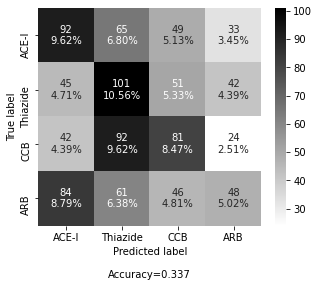

In [28]:
# function from help_functions
make_confusion_matrix(cf_mtx, categories=['ACE-I','Thiazide','CCB','ARB'], cmap='binary', 
                      figsize=(5,4), title=None)
plt.savefig('confusion_matrix_42.jpg', format='jpg', dpi=300)

#### Vizualisation

In [19]:
# shorten name
dic[2]='Drugs For Urinary Frequency'

In [20]:
# train on all data
estimator = xgb.train(params, xgb.DMatrix(X, label=y, feature_names=list(dic.values())), 
                      num_boost_round, verbose_eval=False)

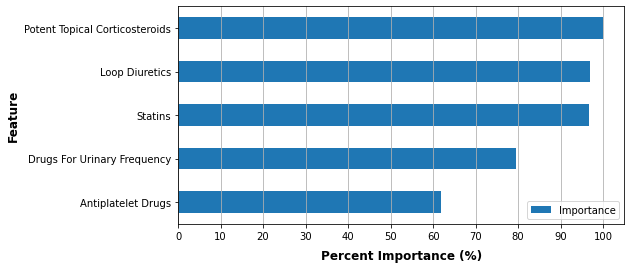

In [21]:
topk = 5

# sort model importances and take top k
sorted_importance = {k:v for k,v in sorted(estimator.get_score(importance_type='gain').items(),
                                           key=lambda item: item[1], reverse=True)[:topk]}

df = pd.DataFrame({'Feature': list(sorted_importance.keys())[:topk],
                   'Importance': 100*np.array(list(sorted_importance.values())[:topk])/\
                                 max(np.array(list(sorted_importance.values())))})
ax = df.plot(x='Feature', kind='barh', figsize=(8,4))
ax.invert_yaxis()
plt.xlabel('Percent Importance (%)', labelpad=8, fontsize='large', fontweight='demibold')
plt.ylabel('Feature', fontsize='large', fontweight='demibold')
plt.grid(axis='x')
ax.set_xticks(ticks=np.linspace(0,100,11))
plt.savefig('feature_importance_mc.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()